<a href="https://colab.research.google.com/github/ThumbRocket/Pre-Learning_AI_Model/blob/main/3_CNN_LesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import sys
import nbformat
import json
import subprocess
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#!kaggle datasets download -d alexandremoritz/simulated-analog-wafer-pattern-recognition
#!unzip -o simulated-analog-wafer-pattern-recognition.zip

df = pd.DataFrame()
all_images=[]
all_labels=[]
test_images = []
test_labels = []

for i in range(1, 5):
    tmp_df = pd.read_csv("training_"+str(i)+".csv",
                         sep=";",
                         decimal=",",
                         usecols=["lot", "wafer", "x", "y", "ring", "spot", "trend", "twospots", "crescent"],
                         dtype={
                             "lot":np.string_,
                             "wafer":np.int16,
                             "x":np.int16,
                             "y":np.int16,
                             "ring":np.float64,
                             "spot":np.float64,
                             "trend":np.float64,
                             "twospot":np.float64,
                             "cresent":np.float64}
                         )

    df = pd.concat([df, tmp_df])

category = df.columns[4:].to_list()

def create_image(df, wafer_id, pattern):

    Image =np.zeros([193, 115])

    for i, row in df[df["wafer"]==wafer_id].iterrows():
        Image[(row["y"]-1), row["x"]-1] = row[pattern]

    return Image

def create_images_from_df(df, wafer_id):

    images=[]
    labels=[]

    for index, feature in enumerate(category):
        image = np.copy(df[df["wafer"]==wafer_id].pivot(index="x", columns="y", values=feature).fillna(0).values)
        images.append(image)
        labels.append(index)

    return images, labels

for id in tqdm(df["wafer"].unique()):
    image, label = create_images_from_df(df, id)

    all_images.extend(image)
    all_labels.extend(label)

df_loaded = pd.DataFrame({"image" : all_images, "label" : all_labels})

100%|██████████| 800/800 [00:57<00:00, 13.81it/s]


In [4]:
df_loaded, df_loaded.shape

(                                                  image  label
 0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 ...                                                 ...    ...
 3995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 3996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 3997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 3999  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 
 [4000 rows x 2 columns],
 (4000, 2))

In [5]:
category

['ring', 'spot', 'trend', 'twospots', 'crescent']

In [6]:
pivot = int((len(df_loaded) * 0.8))
pivot

3200

In [7]:
train_df = df_loaded[:pivot]

In [8]:
train_df.shape, train_df

((3200, 2),
                                                   image  label
 0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 ...                                                 ...    ...
 3195  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 3196  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 3197  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3198  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 3199  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 
 [3200 rows x 2 columns])

In [9]:
test_df = df_loaded[pivot:]

In [10]:
test_df.shape, test_df

((800, 2),
                                                   image  label
 3200  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 3201  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 3202  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3203  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 3204  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 ...                                                 ...    ...
 3995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0
 3996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
 3997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      2
 3998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      3
 3999  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      4
 
 [800 rows x 2 columns])

In [11]:
class WaferDataset(Dataset):
    def __init__(self, dataframe, transform) -> None:
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image = torch.tensor(self.dataframe.iloc[index, 0]).float()
        label = torch.tensor(self.dataframe.iloc[index, 1]).float()

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
def minmax_scaling(image):

    min_val = torch.min(image)
    max_val = torch.max(image)

    if max_val - min_val < 1e-9:
        return image
    else:
        return (image - min_val) / (max_val - min_val)

tranform = transforms.Compose([
    transforms.Lambda(minmax_scaling),
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

In [13]:
train_Dataset = WaferDataset(train_df, transform=tranform)
test_Dataset = WaferDataset(test_df, transform=tranform)

In [14]:
train_Dataset, test_Dataset, len(train_Dataset), train_Dataset[0]

(<__main__.WaferDataset at 0x7a725bc9b1f0>,
 3200,
 (tensor([[[0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
           [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
           [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
           ...,
           [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
           [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
           [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863]]]),
  tensor(0.)))

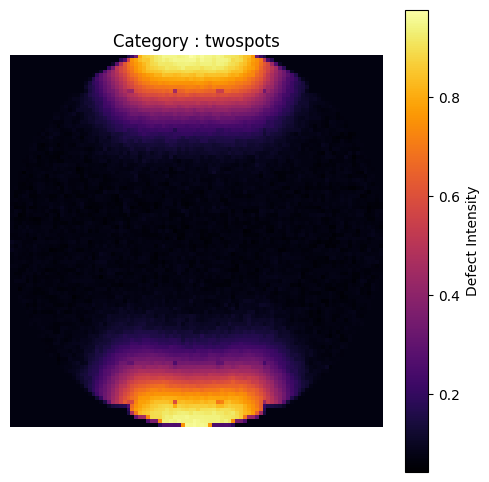

In [15]:
image, label = train_Dataset[18]

plt.figure(figsize=(6, 6))
plt.imshow(image.squeeze(0), cmap="inferno")
plt.title(f"Category : {category[label.int()]}")
plt.axis("off")
plt.colorbar(label="Defect Intensity")
plt.show()

In [16]:
batch_size = 32
train_loader = DataLoader(train_Dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_Dataset, batch_size=batch_size, shuffle=False)

In [17]:
len(train_loader), len(train_Dataset)

(100, 3200)

In [18]:
len(category)

5

In [19]:
class CNNClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=13, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 17 * 17, 128)
        self.fc2 = nn.Linear(128, len(category))

    def forward(self, x):

        # Layer 1   input 96 x 96
        x = self.conv1(x)   # output shape : 16x84x84
        x = F.relu(x)
        x = self.pool(x)    # output shape : 16x42x42

        x = self.conv2(x)   # output shape : 32x34x34
        x = F.relu(x)
        x = self.pool(x)     # output shape : 32x17x17

        x = x.view(-1, 32*17*17)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

In [20]:
model = CNNClassifier()

In [21]:
model

CNNClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(13, 13), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9248, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [22]:
def train_model(model, train_loader, optimizer, criterion, epochs, device):

    model.to(device)

    for epoch in range(epochs):
        model.train()

        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = total_loss / total
        train_accuracy = correct / total

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}")

    return model

In [23]:
optimizer = optim.SGD(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [24]:
trained_model = train_model(model,
            train_loader,
            optimizer,
            criterion,
            epochs=epochs,
            device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10] - Train Loss: 1.6096, Train Accuracy: 0.2181
Epoch [2/10] - Train Loss: 1.6093, Train Accuracy: 0.2166
Epoch [3/10] - Train Loss: 1.6090, Train Accuracy: 0.2134
Epoch [4/10] - Train Loss: 1.6087, Train Accuracy: 0.2353
Epoch [5/10] - Train Loss: 1.6084, Train Accuracy: 0.3106
Epoch [6/10] - Train Loss: 1.6081, Train Accuracy: 0.3853
Epoch [7/10] - Train Loss: 1.6078, Train Accuracy: 0.3600
Epoch [8/10] - Train Loss: 1.6074, Train Accuracy: 0.3453
Epoch [9/10] - Train Loss: 1.6071, Train Accuracy: 0.3334
Epoch [10/10] - Train Loss: 1.6068, Train Accuracy: 0.3144


In [25]:
def test_model(model, test_loader, criterion, device):

    model.eval()
    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels.long())
            total_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    avg_test_loss = total_loss / total
    test_accuracy = correct / total

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return avg_test_loss, test_accuracy

In [26]:
test_loss, test_accuracy = test_model(trained_model,
                                      test_loader,
                                      criterion, device=device)

print(f"Test loss: {test_loss} | Test Accuracy: {test_accuracy}")

Test Loss: 1.6066, Test Accuracy: 0.3088
Test loss: 1.6066065835952759 | Test Accuracy: 0.30875
